In [1]:
import sys
sys.path.append('..')

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import scipy

from ray_delay.device_simulator.noise_model_patch import NoiseModelPatch
from ray_delay.device_simulator.stim_simulator.memory import MemoryPatch

In [2]:
dx = 7
dz = 7
dm = 7

patch = NoiseModelPatch(MemoryPatch(dx, dz, dm))
patch.noise_model.save_error_vals = True
center_qubit = patch.patch.device[dx][dz].idx

<Axes: >

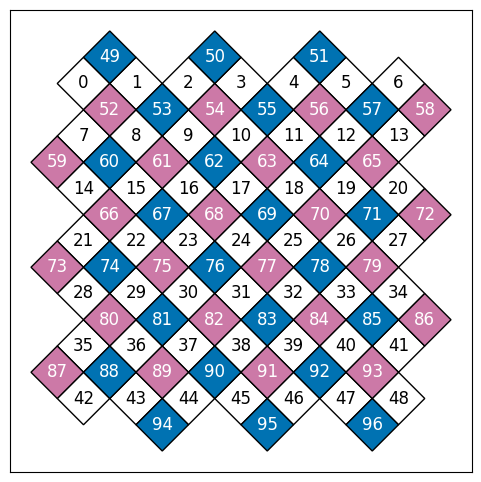

In [3]:
patch.patch.plot_qubit_vals()

In [4]:
cycles_before_ray = 10**3
cycles_after_ray = 10**4
ray_radius = 3
batch_size = 10**2

# Getting baseline and cosmic-ray-induced detector fractions

In [5]:
syndrome_qubits = patch.patch.get_syndrome_qubits()

In [6]:
patch.reset()
baseline_err_rate = patch.patch.count_logical_errors()[0]
baseline_fractions = np.mean(patch.patch.count_detection_events(1e6, return_full_data=True)[0], axis=0)

patch.force_cosmic_ray(8, ray_radius)
ray_err_rate = patch.patch.count_logical_errors()[0]
ray_fractions = np.mean(patch.patch.count_detection_events(1e6, return_full_data=True)[0], axis=0)

In [7]:
baseline_fractions

array([0.00129933, 0.001342  , 0.00134433, 0.002623  , 0.00259417,
       0.0024235 , 0.00256083, 0.0027105 , 0.00275267, 0.002739  ,
       0.00271   , 0.002575  , 0.0025525 , 0.0027075 , 0.00272967,
       0.0027185 , 0.0027445 , 0.00255433, 0.00245033, 0.00260867,
       0.00259183, 0.0013685 , 0.0013475 , 0.00129867, 0.00240817,
       0.002544  , 0.0025995 , 0.0012975 , 0.00136367, 0.00267633,
       0.0026705 , 0.00252467, 0.00255067, 0.00270267, 0.0026825 ,
       0.00135867, 0.00139583, 0.0026965 , 0.0027125 , 0.00249883,
       0.00251483, 0.002721  , 0.00270633, 0.00138267, 0.00133833,
       0.00261217, 0.00258117, 0.00243183])

In [8]:
x = 1.23e-4

In [9]:
exponent, rem = np.divmod(np.log10(x), 1)
print(10**rem)

1.2300000000000004


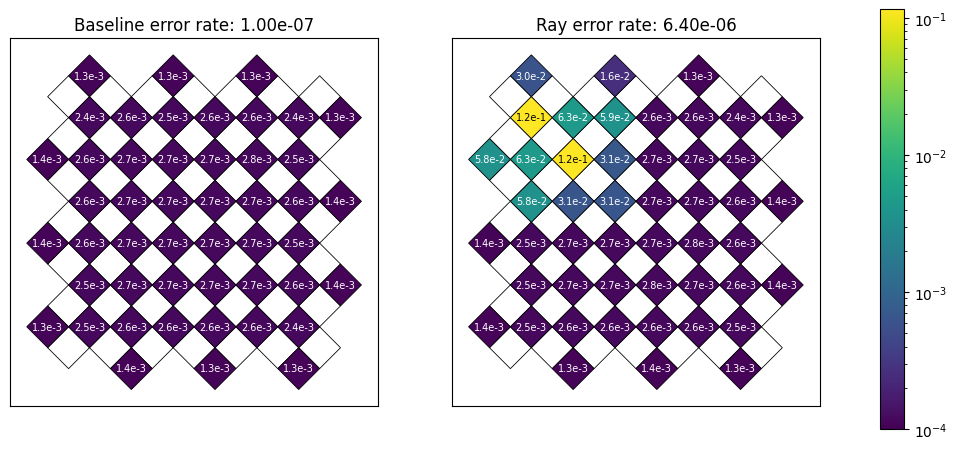

In [10]:
# todo: make function in patch that draws the patch with arbitrary values
# plotted at each qubit / connection (then we can plot the fractions by
# specifying values for only the ancilla qubits)

vmin = 1e-4
vmax = np.max(ray_fractions)
norm = mpl.colors.LogNorm
cmap = 'viridis'
fig,ax = plt.subplots(1, 2, figsize=(12,6))

plot_vals = np.full(len(patch.patch.all_qubits), np.nan)
for i,qubit in enumerate(syndrome_qubits):
    plot_vals[qubit.idx] = baseline_fractions[i]
patch.patch.plot_qubit_vals(qubit_vals=plot_vals, ax=ax[0], font_size=7, vmin=vmin, vmax=vmax, norm=norm, plot_text='val', cmap_name=cmap)
ax[0].set_title('Baseline error rate: {:.2e}'.format(baseline_err_rate))

plot_vals = np.full(len(patch.patch.all_qubits), np.nan)
for i,qubit in enumerate(syndrome_qubits):
    plot_vals[qubit.idx] = ray_fractions[i]
patch.patch.plot_qubit_vals(qubit_vals=plot_vals, ax=ax[1], font_size=7, vmin=vmin, vmax=vmax, norm=norm, plot_text='val', cmap_name=cmap)
ax[1].set_title('Ray error rate: {:.2e}'.format(ray_err_rate))

fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.02, 0.7])
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm(vmin=vmin, vmax=vmax), cmap=cmap), cax=cbar_ax)

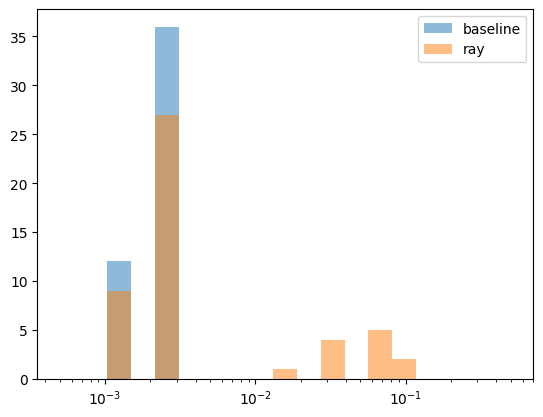

In [11]:
bins = np.geomspace(5e-4, 5e-1, 20)

plt.hist(baseline_fractions, bins, alpha=0.5, label='baseline')
plt.hist(ray_fractions, bins, alpha=0.5, label='ray')
plt.legend()
plt.xscale('log')
plt.show()

Text(0.5, 1.0, 'T1 times on cosmic ray impact')

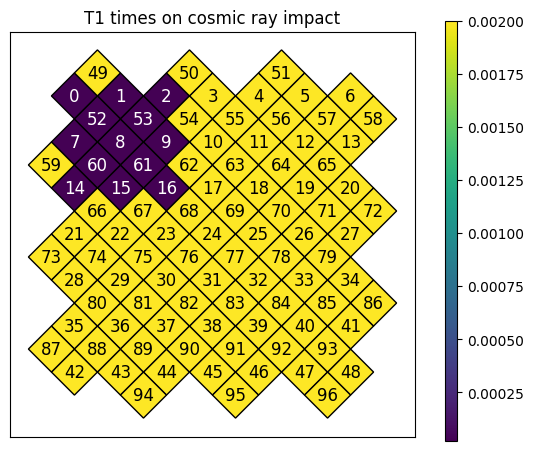

In [12]:
plot_vals = np.full(len(patch.patch.all_qubits), np.nan)
for i,val in patch.noise_model.get_error_val_dict()['T1'].items():
    plot_vals[i] = val
ax = patch.patch.plot_qubit_vals(plot_vals)
ax.set_title('T1 times on cosmic ray impact')

# Number of rounds required for a high-confidence prediction

### Method 1: looking at individual stabilizer syndrome rate

In [13]:
mean_baseline_detections = np.sum(baseline_fractions)
mean_ray_detections = np.sum(ray_fractions)

In [14]:
thresholds = [0.99, 0.999, 0.9999]
window_sizes = [10, 50, 100, 500, 1000]

In [15]:
scipy.stats.binom.ppf(0.00001, 100, 0.5)

29.0

In [16]:
detection_error_data = []
false_positive_rates = []
detection_thresholds = []
for threshold in thresholds:
    threshold_detection_data = []
    threshold_false_positive_rates = []
    detection_threshold_data = []
    for window_size in window_sizes:
        detection_threshold = scipy.stats.binom.ppf(threshold, window_size, mean_baseline_detections)
        detection_threshold_data.append(detection_threshold)
        threshold_false_positive_rates.append(1-scipy.stats.binom.cdf(detection_threshold, window_size, mean_baseline_detections))
        cumulative_no_detection_probs = []
        for possible_detection_latency in range(1, max(window_sizes)+1):
            windowed_syndrome_rate = mean_baseline_detections*(1-possible_detection_latency/window_size) + mean_ray_detections*(possible_detection_latency/window_size)
            detection_prob = 1-scipy.stats.binom.cdf(detection_threshold, window_size, windowed_syndrome_rate)
            if len(cumulative_no_detection_probs) == 0:
                cumulative_no_detection_probs = [1-detection_prob]
            else:
                cumulative_no_detection_probs.append(cumulative_no_detection_probs[-1]*(1-detection_prob))
        threshold_detection_data.append(cumulative_no_detection_probs)
    detection_thresholds.append(detection_threshold_data)
    detection_error_data.append(threshold_detection_data)
    false_positive_rates.append(threshold_false_positive_rates)

In [17]:
detection_thresholds

[[4.0, 11.0, 19.0, 72.0, 134.0],
 [5.0, 13.0, 22.0, 78.0, 142.0],
 [6.0, 15.0, 24.0, 83.0, 149.0]]

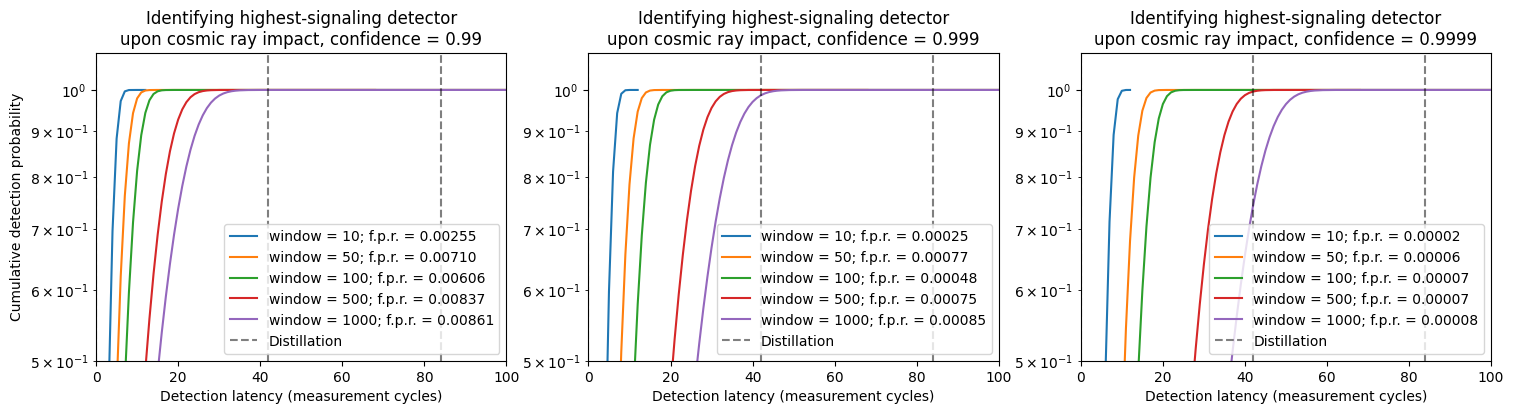

In [18]:
fig,ax = plt.subplots(1,len(thresholds), figsize=(len(thresholds)*6,4))

for i,thresh in enumerate(thresholds):
    ax[i].plot(1-np.array(detection_error_data[i]).T, label=[f'window = {w}; f.p.r. = {false_positive_rates[i][j]:0.5f}' for j,w in enumerate(window_sizes)])
    # plt.plot(false_positive_rates[2])
    ax[i].set_ylim(5e-1,1.1)
    ax[i].set_xlim(0, 100)
    
    cycles_per_distillation = 6*dm
    made_label = False
    for j in range(int(ax[i].get_xlim()[1])):
        if j % cycles_per_distillation == 0:
            if made_label:
                ax[i].axvline(j, color='k', linestyle='--', alpha=0.5)
            else:
                ax[i].axvline(j, color='k', linestyle='--', alpha=0.5, label='Distillation')
                made_label = True
            
    ax[i].legend()
    ax[i].set_yscale('log')
    ax[i].set_xlabel('Detection latency (measurement cycles)')
    if i == 0:
        ax[i].set_ylabel('Cumulative detection probability')
    ax[i].set_title(f'Identifying highest-signaling detector\nupon cosmic ray impact, confidence = {thresh}')
plt.show()


In [19]:
# This cell takes about 11 minutes to run

patch.noise_model.reset()
baseline_err_rate = patch.patch.count_logical_errors()[0]
baseline_syndromes = patch.patch.count_detection_events(cycles_before_ray, return_full_data=True)[3]

for i in range(cycles_before_ray // batch_size):
    # so that noise model saves its values
    patch.step(0)

patch.force_cosmic_ray(center_qubit, ray_radius)
err_rates = [baseline_err_rate]*(cycles_before_ray // batch_size)
syndromes = [baseline_syndromes]
for i in range(cycles_after_ray // batch_size):
    err_rates.append(patch.patch.count_logical_errors()[0])
    syndromes.append(patch.patch.count_detection_events(batch_size, return_full_data=True)[3])
    patch.step(patch.patch.cycle_time()*batch_size)

KeyboardInterrupt: 

In [ ]:
patch.noise_model.active_cosmic_rays[0].affected_qubits

[17, 9, 10, 11, 48, 49, 16, 18, 54, 55, 23, 24, 25]

In [ ]:
tlist = np.cumsum([patch.patch.cycle_time()*batch_size]*len(err_rates))
all_syndromes = np.concatenate(syndromes)

In [ ]:
averaged_syndromes = [np.mean(all_syndromes[i*batch_size:(i+1)*batch_size]) for i in range(all_syndromes.shape[0]//batch_size)]

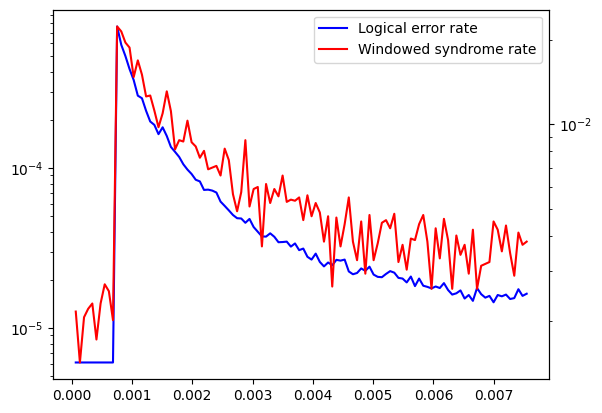

In [ ]:
fig,ax = plt.subplots()
ax1 = ax.twinx()

ln = ax.plot(tlist, err_rates, c='b', label='Logical error rate')
ln1 = ax1.plot(tlist, averaged_syndromes, c='r', label='Windowed syndrome rate')

# shared legend
lns = ln+ln1
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0)

ax.set_yscale('log')
ax1.set_yscale('log')

Should somehow quantify how much of an increased logical error rate we can
reliably detect. Find relationship between logical error rate and average
syndrome rate across whole patch, for cosmic rays at random locations on chip.

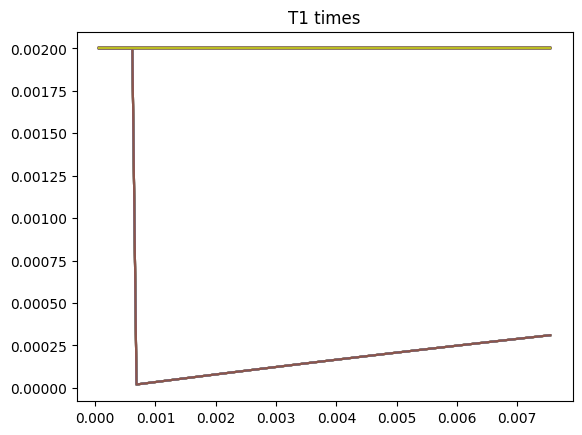

In [ ]:
t1_vals = np.array([[vals['T1'][q] for q in range(len(patch.patch.all_qubits))] for vals in patch.noise_model.error_val_history[1:]])
# t1_vals = t1_vals[[0]*(cycles_before_ray // batch_size) + list(range(cycles_after_ray // batch_size))]

plt.plot(tlist, t1_vals)
plt.title('T1 times')
plt.show()